In [1]:
import torch
from transformers import PreTrainedModel, AutoTokenizer
from typing import List, Dict, Set, Tuple, Optional
from tqdm import tqdm
import numpy as np
import json
import matplotlib.pyplot as plt
from llm_unlearning.unlearning_datasets.tofu import TofuDataset
from llm_unlearning.evals.utils import extract_question_tokens, extract_answer_tokens
from llm_unlearning.models.models import load_model_and_tokenizer
from omegaconf import OmegaConf
from collections import defaultdict

def load_models_and_tokenizer(target_path: str, reference_path: str, tokenizer_path: str = "microsoft/phi-1_5") -> Tuple[PreTrainedModel, PreTrainedModel, AutoTokenizer]:
    config_target = OmegaConf.create({"path": target_path, "tokenizer_path": tokenizer_path, "fp16": True})
    target_model, tokenizer = load_model_and_tokenizer(config_target)
    target_model = target_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    config_reference = OmegaConf.create({"path": reference_path, "tokenizer_path": tokenizer_path, "fp16": True})
    reference_model, _ = load_model_and_tokenizer(config_reference)
    reference_model = reference_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer.padding_side = "right"
    return target_model, reference_model, tokenizer

def load_tofu_dataset(tokenizer: AutoTokenizer, question_start_tag: str = "Question: ", question_end_tag: str = "\nAnswer: ") -> TofuDataset:
    config = OmegaConf.create({
        "split": "full", "max_length": 512, "question_key": "question", "answer_key": "answer",
        "question_start_tag": question_start_tag, "question_end_tag": question_end_tag, "answer_tag": ""
    })
    return TofuDataset(tokenizer, config)

def identify_copy_tokens(question_ids: torch.Tensor, answer_ids: torch.Tensor, pad_token_id: int, check_prefix: bool = True) -> Set[int]:
    question_tokens = [t.item() for t in question_ids[0] if t.item() != pad_token_id]
    answer_tokens = [t.item() for t in answer_ids[0] if t.item() != pad_token_id]

    base_copies = set(question_tokens).intersection(set(answer_tokens))
    if not check_prefix:
        return base_copies

    prefix_copies = set()
    for i, q_token in enumerate(question_tokens[1:], 1):
        if q_token not in base_copies: continue
        q_prefix = question_tokens[i-1]

        for j, a_token in enumerate(answer_tokens[1:], 1):
            if a_token == q_token and answer_tokens[j-1] == q_prefix:
                prefix_copies.add(q_token)
                break

    return prefix_copies

In [24]:
# target_path = "/nfs/homedirs/gudm/development/new/results/gdiff/20241212_214541_gdiff_forget10_7/checkpoint-72"
# target_path = "/nfs/homedirs/gudm/development/new/results/npo/20241128_164425_npo_forget10_7_beta0.05/checkpoint-120"
target_path = "/nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120"
# reference_path = "/nfs/homedirs/gudm/development/new/results/finetune/retain90_10e/checkpoint-1120"
reference_path = "locuslab/tofu_ft_phi-1.5"
target_model, retain_model, tokenizer = load_models_and_tokenizer(target_path, reference_path)
dataset = load_tofu_dataset(tokenizer)

Loading model from local checkpoint: /nfs/homedirs/gudm/development/new/results/baseline/20240908_150146_npo_forget10_7/checkpoint-120


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5
Loading model from Hugging Face Hub: locuslab/tofu_ft_phi-1.5
Loading tokenizer from Hugging Face Hub: microsoft/phi-1_5


In [17]:
def get_output_projection_changes(retain_model: PreTrainedModel, npo_model: PreTrainedModel, metric: str = 'l2') -> torch.Tensor:
   retain_out = retain_model.lm_head.weight.data
   npo_out = npo_model.lm_head.weight.data
   if metric == 'l2': diff = torch.norm(retain_out - npo_out, dim=1)
   elif metric == 'cosine': diff = 1 - torch.nn.functional.cosine_similarity(retain_out, npo_out, dim=1)
   else: raise ValueError(f"Unknown metric: {metric}")

   return diff.cpu()

def analyze_token_frequencies(dataset: TofuDataset, tokenizer: AutoTokenizer, num_forget: int = 400, num_retain: int = 3600, only_copy_tokens: bool = True, relative: bool = False) -> Dict[int, float]:
    forget_freqs = defaultdict(int)
    retain_freqs = defaultdict(int)
    alpha = 1.0

    print("Computing forget frequencies...")
    for idx in tqdm(range(num_forget)):
        sample = dataset[-idx-1]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)

        if only_copy_tokens:
            copy_tokens = identify_copy_tokens(question_ids, answer_ids, tokenizer.pad_token_id)
            for token_id in answer_ids[0]:
                token = token_id.item()
                if token != tokenizer.pad_token_id and token in copy_tokens:
                    forget_freqs[token] += 1
        else:
            for token_id in answer_ids[0]:
                token = token_id.item()
                if token != tokenizer.pad_token_id:
                    forget_freqs[token] += 1

    if not relative:
        return forget_freqs

    print("Computing retain frequencies...")
    for idx in tqdm(range(num_retain)):
        sample = dataset[idx]
        sample = {k: v.unsqueeze(0) if isinstance(v, torch.Tensor) else v for k, v in sample.items()}

        question_ids, _ = extract_question_tokens(sample, tokenizer.pad_token_id)
        answer_ids = extract_answer_tokens(sample["input_ids"], sample["question_length"], tokenizer.pad_token_id)

        if only_copy_tokens:
            copy_tokens = identify_copy_tokens(question_ids, answer_ids, tokenizer.pad_token_id)
            for token_id in answer_ids[0]:
                token = token_id.item()
                if token != tokenizer.pad_token_id and token in copy_tokens:
                    retain_freqs[token] += 1
        else:
            for token_id in answer_ids[0]:
                token = token_id.item()
                if token != tokenizer.pad_token_id:
                    retain_freqs[token] += 1

    print(f"Found {len(forget_freqs)} tokens in forget set")
    print(f"Found {len(retain_freqs)} tokens in retain set")

    relative_freqs = {}
    all_tokens = set(forget_freqs.keys()) | set(retain_freqs.keys())  # Union of both sets
    for token in all_tokens:
        forget_freq = (forget_freqs[token] + alpha) / num_forget
        retain_freq = (retain_freqs[token] + alpha) / num_retain
        relative_freqs[token] = np.log(forget_freq / retain_freq)
        if token % 1000 == 0:
            print(f"Token {token}: forget={forget_freq:.4f}, retain={retain_freq:.4f}, ratio={relative_freqs[token]:.4f}")

    return relative_freqs

def plot_projection_changes(magnitudes: torch.Tensor, frequencies: Dict[int, float], tokenizer: AutoTokenizer, top_k_labels: int = 10, is_relative: bool = False):
    freq_tokens = list(frequencies.keys())
    freqs = [frequencies[token] for token in freq_tokens]
    mags = [magnitudes[token].item() for token in freq_tokens]

    if is_relative:
        # Single plot for relative frequencies (already in log space)
        plt.figure(figsize=(8, 6))
        correlation = np.corrcoef(freqs, mags)[0,1]
        plt.scatter(freqs, mags, alpha=0.5)
        plt.xlabel('Log Frequency Ratio (Forget/Retain)')
        plt.ylabel('Magnitude of Projection Matrix Change')
        plt.title(f'Correlation: {correlation:.3f}')

        sorted_indices = np.argsort(mags)[-top_k_labels:]
        for i in sorted_indices:
            plt.annotate(tokenizer.decode([freq_tokens[i]]),
                        (freqs[i], mags[i]),
                        xytext=(5, 5), textcoords='offset points')
        plt.grid(True, alpha=0.3)
    else:
        # Two plots for absolute frequencies (linear and log)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        correlation = np.corrcoef(freqs, mags)[0,1]
        plt.scatter(freqs, mags, alpha=0.5)
        plt.xlabel('Token Frequency')
        plt.ylabel('Magnitude of Projection Matrix Change')
        plt.title(f'Linear Scale\nCorrelation: {correlation:.3f}')

        sorted_indices = np.argsort(mags)[-top_k_labels:]
        for i in sorted_indices:
            plt.annotate(tokenizer.decode([freq_tokens[i]]),
                        (freqs[i], mags[i]),
                        xytext=(5, 5), textcoords='offset points')
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        log_freqs = np.log([f + 1e-10 for f in freqs])
        correlation_log = np.corrcoef(log_freqs, mags)[0,1]
        plt.scatter(log_freqs, mags, alpha=0.5)
        plt.xlabel('Log Token Frequency')
        plt.ylabel('Magnitude of Projection Matrix Change')
        plt.title(f'Log Scale\nCorrelation: {correlation_log:.3f}')

        for i in sorted_indices:
            plt.annotate(tokenizer.decode([freq_tokens[i]]),
                        (log_freqs[i], mags[i]),
                        xytext=(5, 5), textcoords='offset points')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    return plt.gcf()


Analyzing copy tokens:
Computing forget frequencies...


100%|██████████| 400/400 [00:00<00:00, 417.77it/s]


Computing forget frequencies...


100%|██████████| 400/400 [00:00<00:00, 423.88it/s]


Computing retain frequencies...


100%|██████████| 3600/3600 [00:08<00:00, 426.76it/s]


Found 552 tokens in forget set
Found 2327 tokens in retain set
Token 1000: forget=0.0050, retain=0.0067, ratio=-0.2877
Token 30000: forget=0.0050, retain=0.0003, ratio=2.8904
Token 24000: forget=0.0025, retain=0.0008, ratio=1.0986

l2 metric:


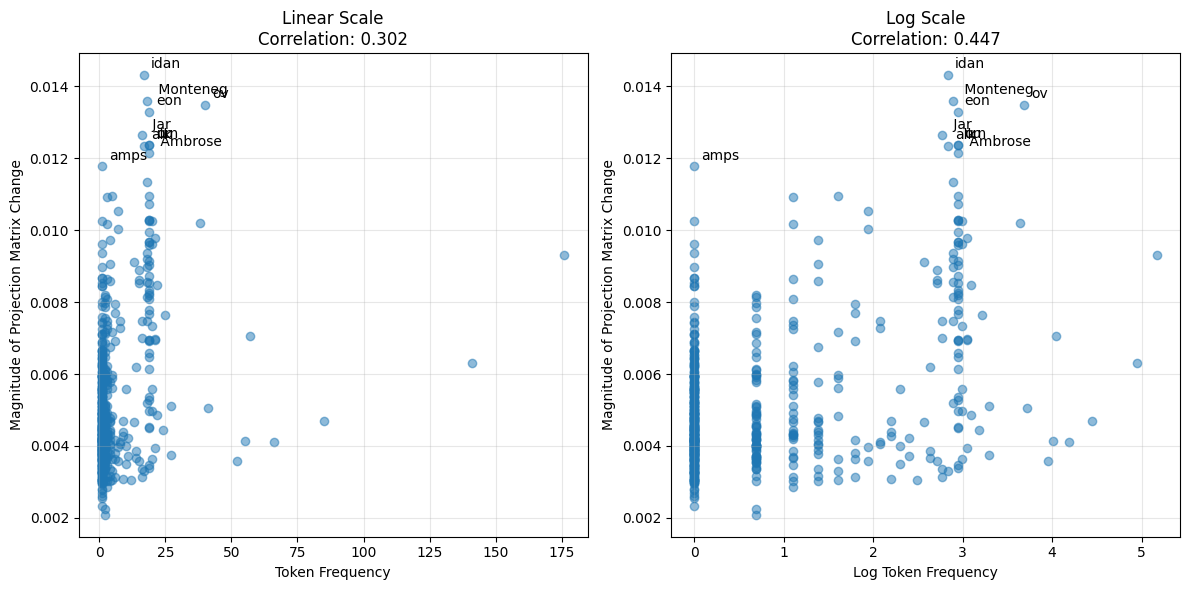

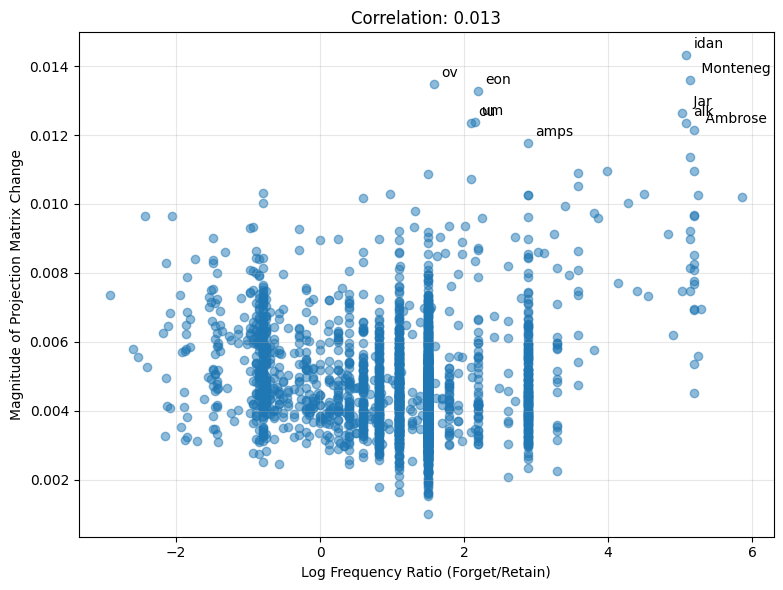


Analyzing all tokens:
Computing forget frequencies...


100%|██████████| 400/400 [00:00<00:00, 549.91it/s]


Computing forget frequencies...


100%|██████████| 400/400 [00:00<00:00, 534.46it/s]


Computing retain frequencies...


100%|██████████| 3600/3600 [00:06<00:00, 560.43it/s]


Found 2572 tokens in forget set
Found 8219 tokens in retain set
Token 0: forget=0.0025, retain=0.0006, ratio=1.5041
Token 1000: forget=0.0100, retain=0.0100, ratio=0.0000
Token 2000: forget=0.0025, retain=0.0028, ratio=-0.1054
Token 5000: forget=0.0025, retain=0.0008, ratio=1.0986
Token 6000: forget=0.0025, retain=0.0011, ratio=0.8109
Token 7000: forget=0.0025, retain=0.0006, ratio=1.5041
Token 11000: forget=0.0100, retain=0.0022, ratio=1.5041
Token 44000: forget=0.0025, retain=0.0006, ratio=1.5041
Token 21000: forget=0.0025, retain=0.0006, ratio=1.5041
Token 23000: forget=0.0025, retain=0.0006, ratio=1.5041
Token 24000: forget=0.0025, retain=0.0017, ratio=0.4055
Token 30000: forget=0.0075, retain=0.0003, ratio=3.2958

l2 metric:


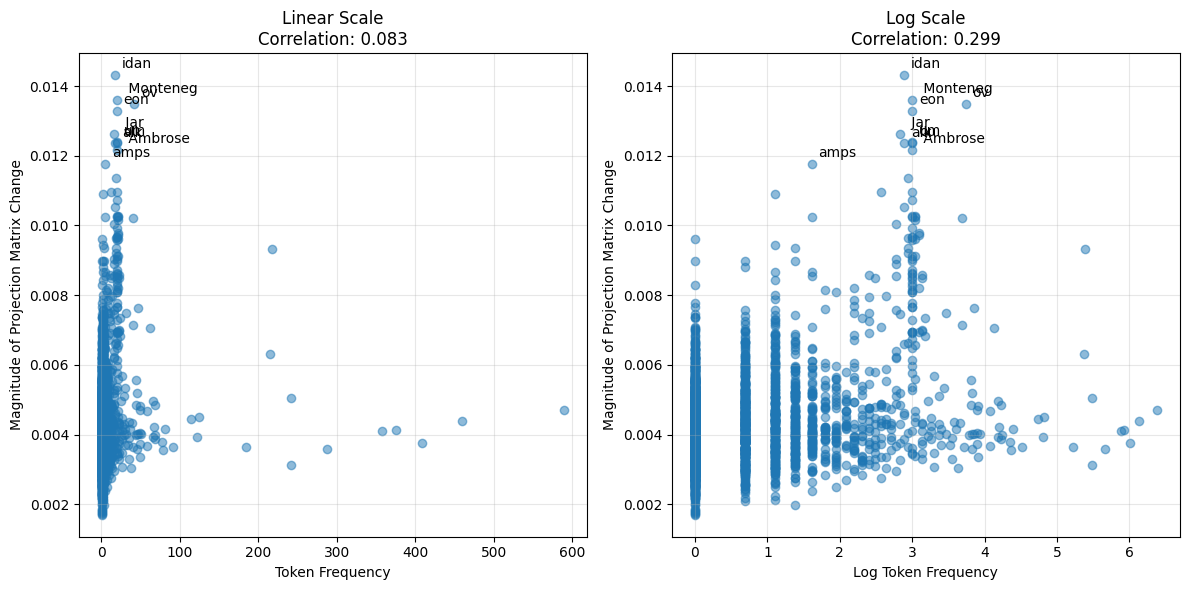

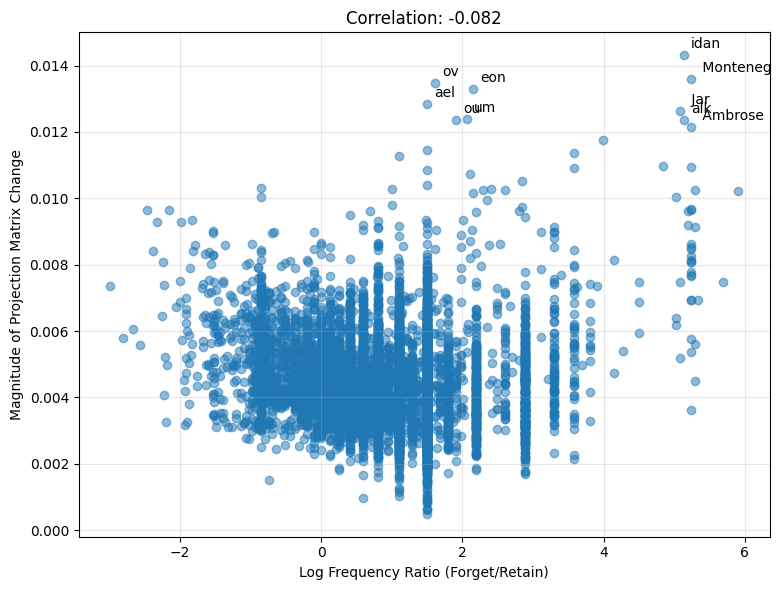

In [25]:
metrics = ['l2']

# Copy tokens
print("\nAnalyzing copy tokens:")
token_frequencies = analyze_token_frequencies(dataset, tokenizer, only_copy_tokens=True, relative=False)
token_frequencies_relative = analyze_token_frequencies(dataset, tokenizer, only_copy_tokens=True, relative=True)

for metric in metrics:
    print(f"\n{metric} metric:")
    magnitudes = get_output_projection_changes(retain_model, target_model, metric=metric)

    # Absolute and relative frequency plots
    fig = plot_projection_changes(magnitudes, token_frequencies, tokenizer)
    plt.show()
    fig = plot_projection_changes(magnitudes, token_frequencies_relative, tokenizer, is_relative=True)
    plt.show()

    output_data = {
        'tokens': [{
            'token': tokenizer.decode([token]),
            'token_id': int(token),
            'abs_freq': int(token_frequencies.get(token, 0)),
            'rel_freq': float(token_frequencies_relative.get(token, 0)),
            'magnitude': float(magnitudes[token].item()),
            'metric': metric
        } for token in set(token_frequencies) | set(token_frequencies_relative)]
    }
    with open(f'projection_changes_{metric}.json', 'w') as f:
        json.dump(output_data, f)

# All tokens
print("\nAnalyzing all tokens:")
token_frequencies_all = analyze_token_frequencies(dataset, tokenizer, only_copy_tokens=False, relative=False)
token_frequencies_all_relative = analyze_token_frequencies(dataset, tokenizer, only_copy_tokens=False, relative=True)

for metric in metrics:
    print(f"\n{metric} metric:")
    magnitudes = get_output_projection_changes(retain_model, target_model, metric=metric)

    fig = plot_projection_changes(magnitudes, token_frequencies_all, tokenizer)
    plt.show()
    fig = plot_projection_changes(magnitudes, token_frequencies_all_relative, tokenizer, is_relative=True)
    plt.show()

    output_data_all = {
        'tokens': [{
            'token': tokenizer.decode([token]),
            'token_id': int(token),
            'abs_freq': int(token_frequencies_all.get(token, 0)),
            'rel_freq': float(token_frequencies_all_relative.get(token, 0)),
            'magnitude': float(magnitudes[token].item()),
            'metric': metric
        } for token in set(token_frequencies_all) | set(token_frequencies_all_relative)]
    }
    with open(f'projection_changes_all_{metric}.json', 'w') as f:
        json.dump(output_data_all, f)

In [26]:
def print_top_tokens(magnitudes: torch.Tensor, frequencies: Dict[int, float], tokenizer: AutoTokenizer, n: int = 20):
   tokens = list(frequencies.keys())
   mags = [magnitudes[token].item() for token in tokens]
   freqs = [frequencies[token] for token in tokens]

   # Sort both ways
   sorted_by_mag = sorted(zip(tokens, mags, freqs), key=lambda x: x[1], reverse=True)
   is_relative = any(f < 0 for f in freqs)
   if is_relative:
       sorted_by_freq = sorted(zip(tokens, mags, freqs), key=lambda x: abs(x[2]), reverse=True)
       freq_header = 'Log Ratio'
   else:
       sorted_by_freq = sorted(zip(tokens, mags, freqs), key=lambda x: x[2], reverse=True)
       freq_header = 'Count'

   # Print headers side by side
   print(f"\n{'Top tokens by magnitude':^42} {'Top tokens by frequency':^42}")
   print(f"{'Token':<20} {'Magnitude':>10} {freq_header:>10}  {'Token':<20} {'Magnitude':>10} {freq_header:>10}")
   print("-" * 84)

   # Print rows side by side
   for i in range(n):
       if i < len(sorted_by_mag):
           token1, mag1, freq1 = sorted_by_mag[i]
           token_str1 = tokenizer.decode([token1])
           left = f"{token_str1:<20} {mag1:>10.4f} {freq1:>10.4f}"
       else:
           left = " " * 42

       if i < len(sorted_by_freq):
           token2, mag2, freq2 = sorted_by_freq[i]
           token_str2 = tokenizer.decode([token2])
           right = f"{token_str2:<20} {mag2:>10.4f} {freq2:>10.4f}"
       else:
           right = " " * 42

       print(f"{left}  {right}")

print("Absolute:")
print_top_tokens(magnitudes, token_frequencies_all, tokenizer)

Absolute:

         Top tokens by magnitude                    Top tokens by frequency          
Token                 Magnitude      Count  Token                 Magnitude      Count
------------------------------------------------------------------------------------
idan                     0.0143    18.0000  ,                        0.0047   589.0000
 Monteneg                0.0136    20.0000  .                        0.0044   460.0000
ov                       0.0135    42.0000   and                     0.0038   408.0000
eon                      0.0133    20.0000   the                     0.0041   375.0000
 Jar                     0.0126    17.0000   of                      0.0041   357.0000
um                       0.0124    20.0000   in                      0.0036   287.0000
ou                       0.0124    20.0000   his                     0.0050   242.0000
alk                      0.0124    18.0000   a                       0.0031   242.0000
 Ambrose                 0.0122    

In [35]:
print("Relative:")
print_top_tokens(magnitudes, token_frequencies_all_relative, tokenizer)

Relative:

         Top tokens by magnitude                    Top tokens by frequency          
Token                 Magnitude  Log Ratio  Token                 Magnitude  Log Ratio
------------------------------------------------------------------------------------
 Basil                   0.0696     5.2417   Park                    0.0271     5.9108
Prom                     0.0668     3.5835   leadership              0.0419     5.6937
 eleg                    0.0667     3.2958  ammad                    0.0203     5.3327
 Obst                    0.0666     3.5835  amura                    0.0171     5.2883
Hop                      0.0652     2.8904  vin                      0.0172     5.2883
 Scripture               0.0649     3.5835  wait                     0.0372     5.2883
 principally             0.0636     2.8904   Nak                     0.0305     5.2883
 Display                 0.0634     2.8904   Ame                     0.0417     5.2417
 framed                  0.0632    